In [ ]:
import pandas as pd
import numpy as np
import json # To parse JSON-like strings
import ast  # For safely evaluating strings containing Python literals

try:
    movies_df = pd.read_csv('/content/tmdb_5000_movies.csv')
    credits_df = pd.read_csv('/content/tmdb_5000_credits.csv')
except FileNotFoundError:
    print("Make sure 'tmdb_5000_movies.csv' and 'tmdb_5000_credits.csv' are in the current directory.")
    exit()

print("--- tmdb_5000_movies.csv (loaded into movies_df) ---")
print(movies_df.head())
print("\n--- tmdb_5000_credits.csv (loaded into credits_df) ---")
print(credits_df.head())

# Rename 'movie_id' in credits_df to 'id' to match the key in movies_df
credits_df.rename(columns={'movie_id': 'id'}, inplace=True)

# Merge the two dataframes on the common 'id' column
df = pd.merge(movies_df, credits_df, on='id')

# Handle the duplicated 'title' column: keep 'title_x' and rename it to 'title'
# The titles should be the same; if not, it indicates a data quality issue.
if 'title_y' in df.columns and 'title_x' in df.columns:
    df.drop('title_y', axis=1, inplace=True)
    df.rename(columns={'title_x': 'title'}, inplace=True)
elif 'title_y' in df.columns and 'title_x' not in df.columns:
    df.rename(columns={'title_y': 'title'}, inplace=True)


print("\n--- Merged DataFrame ---")
print("Shape of Merged DataFrame:", df.shape)
print("\nColumns in Merged DataFrame:", df.columns.tolist())
print("\nMerged DataFrame Info:")
df.info()
print("\nFirst few rows of Merged DataFrame:")
print(df.head())

--- tmdb_5000_movies.csv (loaded into movies_df) ---
      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 

In [ ]:
#Define Target Variables and Select Initial Features

target_cols = ['revenue', 'vote_average']

# Display the selected target columns to verify
print("\n--- Target Columns ---")
print(df[target_cols].head())

# Let's look at a subset of columns we might use or engineer from
print("\n--- Potential Feature Columns (Subset) ---")
potential_feature_preview_cols = [
    'title', 'budget', 'genres', 'keywords', 'popularity',
    'production_companies', 'release_date', 'runtime',
    'vote_count', 'cast', 'crew', 'homepage'
]


print(df[potential_feature_preview_cols + target_cols].head(2))


--- Target Columns ---
      revenue  vote_average
0  2787965087           7.2
1   961000000           6.9
2   880674609           6.3
3  1084939099           7.6
4   284139100           6.1

--- Potential Feature Columns (Subset) ---
                                      title     budget  \
0                                    Avatar  237000000   
1  Pirates of the Caribbean: At World's End  300000000   

                                              genres  \
0  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   

                                            keywords  popularity  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...  150.437577   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...  139.082615   

                                production_companies release_date  runtime  \
0  [{"name": "Ingenious Film Partners", "id": 289...   2009-12-10    162.0   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...   2007

In [ ]:
#Data Cleaning and Basic Preprocessing


# --- Cleaning 'revenue' and 'budget' ---
# Display current shape and some stats before filtering
print(f"Shape before budget/revenue filtering: {df.shape}")
print("Number of movies with budget <= 1000:", (df['budget'] <= 1000).sum())
print("Number of movies with revenue <= 1000:", (df['revenue'] <= 1000).sum())

# Filter out movies with very low budget or revenue
# Similarly for revenue. This helps in getting more meaningful log transformations.
df = df[df['budget'] > 1000]
df = df[df['revenue'] > 1000]

print(f"Shape after filtering low budget/revenue: {df.shape}")

# Log transform 'budget' and 'revenue'
# We use np.log1p which computes log(1 + x) to naturally handle any zeros if they were present
# and to reduce skewness.
df['budget_log'] = np.log1p(df['budget'])
df['revenue_log'] = np.log1p(df['revenue'])

# --- Handling missing 'runtime' ---
print("Missing 'runtime' values before imputation:", df['runtime'].isnull().sum())
median_runtime = df['runtime'].median()
df['runtime'].fillna(median_runtime, inplace=True)
print("Missing 'runtime' values after imputation:", df['runtime'].isnull().sum())


print(df[['budget_log', 'revenue_log', 'vote_average']].describe())

# Display first few rows with new log columns
print("\nDataFrame head with new log-transformed columns:")
print(df[['title', 'budget', 'budget_log', 'revenue', 'revenue_log', 'runtime']].head())

Shape before budget/revenue filtering: (4803, 22)
Number of movies with budget <= 1000: 1069
Number of movies with revenue <= 1000: 1449
Shape after filtering low budget/revenue: (3211, 22)
Missing 'runtime' values before imputation: 0
Missing 'runtime' values after imputation: 0
        budget_log  revenue_log  vote_average
count  3211.000000  3211.000000   3211.000000
mean     16.857557    17.561020      6.309249
std       1.405516     1.829021      0.872804
min       8.853808     8.111028      0.000000
25%      16.213406    16.666163      5.800000
50%      17.034386    17.840636      6.300000
75%      17.822844    18.808089      6.900000
max      19.755682    21.748578      8.500000

DataFrame head with new log-transformed columns:
                                      title     budget  budget_log  \
0                                    Avatar  237000000   19.283571   
1  Pirates of the Caribbean: At World's End  300000000   19.519293   
2                                   Spectre  

<ipython-input-7-5ae2f861bcaa>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['runtime'].fillna(median_runtime, inplace=True)


In [ ]:
# Step 4: Feature Engineering from JSON-like Columns


# Helper function to parse JSON-like strings safely
def parse_json_col(column_str):
    try:
        # ast.literal_eval is safer for Python literal structures (like list of dicts)
        return ast.literal_eval(column_str)
    except (ValueError, SyntaxError, TypeError): # Added TypeError for potential None values
        return [] # Return empty list if parsing fails or input is not string-like

# --- Engineer 'num_genres' ---
# Apply the parser first, then extract names if needed, or just count
df['genres_list'] = df['genres'].apply(parse_json_col)
df['num_genres'] = df['genres_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# --- Engineer 'num_keywords' ---
df['keywords_list'] = df['keywords'].apply(parse_json_col)
df['num_keywords'] = df['keywords_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# --- Engineer 'num_cast' and 'num_crew' ---
# The 'cast' and 'crew' columns are also JSON-like strings
df['cast_list'] = df['cast'].apply(parse_json_col)
df['num_cast'] = df['cast_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)

df['crew_list'] = df['crew'].apply(parse_json_col)
df['num_crew'] = df['crew_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# --- Engineer 'has_homepage' ---
# Check if 'homepage' column is null or not, convert boolean to int (1 or 0)
df['has_homepage'] = df['homepage'].notna().astype(int)

# --- Engineer 'release_year' and 'release_month' ---
# Ensure 'release_date' is in datetime format
print("Missing 'release_date' values before conversion:", df['release_date'].isnull().sum())
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce') # 'coerce' will turn unparseable dates into NaT

# Drop rows where date conversion might have failed (resulting in NaT)
# or if release_date was already null.
num_rows_before_date_dropna = df.shape[0]
df.dropna(subset=['release_date'], inplace=True)
num_rows_after_date_dropna = df.shape[0]
if num_rows_before_date_dropna != num_rows_after_date_dropna:
    print(f"Dropped {num_rows_before_date_dropna - num_rows_after_date_dropna} rows due to unparseable/missing release_date.")


df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
# df['release_dayofweek'] = df['release_date'].dt.dayofweek # Another option for more detail

print("\nEngineered features head (first 5 rows):")
engineered_cols_to_show = ['title', 'num_genres', 'num_keywords', 'num_cast', 'num_crew', 'has_homepage', 'release_year', 'release_month']
print(df[engineered_cols_to_show].head())

print(f"\nShape of DataFrame after feature engineering: {df.shape}")
print("\nQuick check for NaNs in new engineered features:")
print(df[engineered_cols_to_show].isnull().sum())

Missing 'release_date' values before conversion: 0

Engineered features head (first 5 rows):
                                      title  num_genres  num_keywords  \
0                                    Avatar           4            21   
1  Pirates of the Caribbean: At World's End           3            16   
2                                   Spectre           3             7   
3                     The Dark Knight Rises           4            21   
4                               John Carter           3            16   

   num_cast  num_crew  has_homepage  release_year  release_month  
0        83       153             1          2009             12  
1        34        32             1          2007              5  
2        83       155             1          2015             10  
3       158       217             1          2012              7  
4        27       132             1          2012              3  

Shape of DataFrame after feature engineering: (3211, 35)

Quick c

In [ ]:
# Final Feature Selection and Defining X and y

# Define features (X) and targets (y)
# These are the numerical features we prepared or were already numeric and suitable for direct use.
feature_cols = [
    'budget_log',       # Log-transformed budget
    'popularity',
    'runtime',
    'vote_count',
    'num_genres',
    'num_keywords',
    'num_cast',
    'num_crew',
    'has_homepage',
    'release_year',
    'release_month'
]
# Create the feature matrix X
X = df[feature_cols].copy()

# Create the target matrix y
y = df[['revenue_log', 'vote_average']].copy()


print("\nMissing values in selected features (X) before final fill:")
print(X.isnull().sum())

# Fill any remaining NaNs in X with the median of each column.
for col in X.columns:
    if X[col].isnull().any():
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)
        print(f"Filled NaNs in '{col}' with median: {median_val}")

print("\nMissing values in X after final fill:")
print(X.isnull().sum())

print("\nMissing values in y:")
print(y.isnull().sum())
# Verify shapes
print("\nShape of X (features):", X.shape)
print("Shape of y (targets):", y.shape)

# Display head of X and y to confirm
print("\nHead of X (features):")
print(X.head())
print("\nHead of y (targets):")
print(y.head())


Missing values in selected features (X) before final fill:
budget_log       0
popularity       0
runtime          0
vote_count       0
num_genres       0
num_keywords     0
num_cast         0
num_crew         0
has_homepage     0
release_year     0
release_month    0
dtype: int64

Missing values in X after final fill:
budget_log       0
popularity       0
runtime          0
vote_count       0
num_genres       0
num_keywords     0
num_cast         0
num_crew         0
has_homepage     0
release_year     0
release_month    0
dtype: int64

Missing values in y:
revenue_log     0
vote_average    0
dtype: int64

Shape of X (features): (3211, 11)
Shape of y (targets): (3211, 2)

Head of X (features):
   budget_log  popularity  runtime  vote_count  num_genres  num_keywords  \
0   19.283571  150.437577    162.0       11800           4            21   
1   19.519293  139.082615    169.0        4500           3            16   
2   19.316769  107.376788    148.0        4466           3          

In [ ]:
# Split Data into Training and Testing Sets


from sklearn.model_selection import train_test_split

# Split the data into training (80%) and testing (20%) sets
# random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nShapes of training and testing sets:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Display the first few rows of y_train and y_test to see the split
print("\nHead of y_train:")
print(y_train.head())
print("\nHead of y_test:")
print(y_test.head())


Shapes of training and testing sets:
X_train shape: (2568, 11)
y_train shape: (2568, 2)
X_test shape: (643, 11)
y_test shape: (643, 2)

Head of y_train:
      revenue_log  vote_average
1157    19.063650           6.0
429     19.654398           6.3
1813    19.413778           7.8
476     18.623171           5.9
43      19.732664           5.9

Head of y_test:
      revenue_log  vote_average
739     19.142194           5.8
2809    19.969634           7.5
4345    16.622878           6.9
3260    16.179127           5.9
1782    19.123569           5.8


In [ ]:
# Step 7: Feature Scaling

print("\n--- Step 7: Feature Scaling ---")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# The scaler learns the mean and standard deviation from X_train
X_train_scaled = scaler.fit_transform(X_train)


# We do not fit on X_test to avoid data leakage
X_test_scaled = scaler.transform(X_test)

# X_train_scaled and X_test_scaled are now NumPy arrays.
# For inspection, let's convert them back to DataFrames (optional, but good for viewing)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nFirst 5 rows of scaled X_train (as DataFrame):")
print(X_train_scaled_df.head())

print("\nDescriptive statistics of scaled X_train (should have mean ~0 and std ~1):")
print(X_train_scaled_df.describe())

print("\nFirst 5 rows of scaled X_test (as DataFrame):")
print(X_test_scaled_df.head())

# Note: For model training later, we will use the NumPy arrays: X_train_scaled and X_test_scaled


--- Step 7: Feature Scaling ---

First 5 rows of scaled X_train (as DataFrame):
      budget_log  popularity   runtime  vote_count  num_genres  num_keywords  \
1157    0.482445   -0.073452 -0.609167   -0.199158   -1.483216     -0.779449   
429     0.970801    0.187792 -1.334071    0.065574    0.307101      0.759079   
1813    0.346909    0.571738  0.260717    1.485950   -1.483216      0.451373   
476     0.970801    0.196791 -1.044109    0.150994    0.307101     -1.087154   
43      1.616373    1.134082  0.212390    1.046142    0.307101      0.605226   

      num_cast  num_crew  has_homepage  release_year  release_month  
1157 -0.418405 -0.595456     -0.850582      0.108275       1.480578  
429  -0.418405 -0.595456     -0.850582      0.333234      -0.907503  
1813  1.102421  1.136579      1.175665      0.483207       1.480578  
476   0.789310 -0.254728      1.175665      0.558194       0.585047  
43   -0.507865  0.597093      1.175665      0.558194      -0.608993  

Descriptive stati

In [ ]:
# Step 8: Model Selection and Training

print("\n--- Step 8: Model Selection and Training ---")

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Initialize the base regressor.
# RandomForestRegressor is a good general-purpose choice.

base_regressor = RandomForestRegressor(
    n_estimators=100,     # Number of trees in the forest
    random_state=42,      # For reproducibility
    n_jobs=-1,            # Use all available cores
    max_depth=15,         # Maximum depth of the trees (to prevent overfitting)
    min_samples_split=5,  # Minimum number of samples required to split an internal node
    min_samples_leaf=3    # Minimum number of samples required to be at a leaf node
)

# Wrap the base regressor with MultiOutputRegressor
# This will fit one RandomForestRegressor for 'revenue_log' and another for 'vote_average'
model = MultiOutputRegressor(base_regressor)

# --- Train the model ---
# We use X_train_scaled (the NumPy array) and y_train (can be pandas DataFrame)

model.fit(X_train_scaled, y_train)
print("Model training complete.")

# The 'model' object now contains two fitted RandomForestRegressor instances,
# one for each target variable. You can access them via model.estimators_
if hasattr(model, 'estimators_') and len(model.estimators_) > 0:
    print(f"\nNumber of estimators (one per target): {len(model.estimators_)}")
    print(f"Estimator for target 1 ('revenue_log'): {model.estimators_[0]}")
    print(f"Estimator for target 2 ('vote_average'): {model.estimators_[1]}")
else:
    print("\nEstimators not found or model not fitted as expected.")

# Optional: If you wanted to try a simpler model like Linear Regression:
# base_lr = LinearRegression()
# model_lr = MultiOutputRegressor(base_lr)
# print("\nTraining LinearRegression MultiOutputRegressor...")
# model_lr.fit(X_train_scaled, y_train)
# print("Linear Regression training complete.")
# Then you would use model_lr for predictions and evaluation.


--- Step 8: Model Selection and Training ---
Model training complete.

Number of estimators (one per target): 2
Estimator for target 1 ('revenue_log'): RandomForestRegressor(max_depth=15, min_samples_leaf=3, min_samples_split=5,
                      n_jobs=-1, random_state=42)
Estimator for target 2 ('vote_average'): RandomForestRegressor(max_depth=15, min_samples_leaf=3, min_samples_split=5,
                      n_jobs=-1, random_state=42)


In [ ]:
# Make Predictions


# Use the trained model to make predictions on the scaled test data (X_test_scaled)
y_pred_scaled = model.predict(X_test_scaled) # Output will be a NumPy array

print(f"\nShape of predictions (y_pred_scaled): {y_pred_scaled.shape}")
print("Predictions are for (revenue_log, vote_average)")

# Display the first 5 predictions
print("\nFirst 5 raw predictions (scaled, for revenue_log and vote_average):")
print(y_pred_scaled[:5])

# For comparison, let's look at the first 5 actual values from y_test
# y_test is a pandas DataFrame, so we use .head() or .iloc[:5]
print("\nFirst 5 actual test values (y_test):")
print(y_test.head().values) # .values to get NumPy array for consistent display with y_pred_scaled

# y_pred_scaled contains:
# Column 0: Predictions for 'revenue_log'
# Column 1: Predictions for 'vote_average'


--- Step 9: Make Predictions ---

Shape of predictions (y_pred_scaled): (643, 2)
Predictions are for (revenue_log, vote_average)

First 5 raw predictions (scaled, for revenue_log and vote_average):
[[18.70975442  6.07976444]
 [18.28359881  7.53643788]
 [16.72808464  7.21112747]
 [16.21347761  6.81662966]
 [17.83420532  7.00999127]]

First 5 actual test values (y_test):
[[19.14219402  5.8       ]
 [19.96963378  7.5       ]
 [16.62287751  6.9       ]
 [16.17912697  5.9       ]
 [19.12356877  5.8       ]]


In [ ]:
# Inverse Transform Revenue Predictions


# y_test is a pandas DataFrame. Let's make a copy to modify for actual revenue.
y_test_actual_scale = y_test.copy()

# y_pred_scaled is a NumPy array. Let's make a copy for the actual scale predictions.
y_pred_actual_scale = y_pred_scaled.copy()


# --- Inverse transform the 'revenue_log' column (index 0) in y_test_actual_scale ---
# This converts the actual log revenue back to the original dollar scale.
y_test_actual_scale.iloc[:, 0] = np.expm1(y_test.iloc[:, 0])
# y_test_actual_scale now contains: [actual revenue, actual vote_average]

# --- Inverse transform the 'revenue_log' predictions (column 0) in y_pred_actual_scale ---
# This converts the predicted log revenue back to the original dollar scale.
y_pred_actual_scale[:, 0] = np.expm1(y_pred_scaled[:, 0])
# y_pred_actual_scale now contains: [predicted revenue, predicted vote_average]


# For safety, ensure no negative predictions for revenue after inverse transform,
# as revenue cannot be negative. np.maximum sets any negative values to 0.
y_pred_actual_scale[:, 0] = np.maximum(0, y_pred_actual_scale[:, 0])


print("\nFirst 5 actual test values (revenue in original scale, vote_average):")
# Displaying as NumPy array for consistency with predicted values
print(y_test_actual_scale.head().values)

print("\nFirst 5 predicted values (revenue in original scale, vote_average):")
print(y_pred_actual_scale[:5])

# Sanity check: Compare one original budget with its log and back
if 'budget' in df.columns and 'budget_log' in df.columns:
    original_budget_example = df['budget'].iloc[0]
    log_budget_example = df['budget_log'].iloc[0]
    reverted_budget_example = np.expm1(log_budget_example)
    print(f"\nSanity check for inverse transform (using budget as an example):")
    print(f"Original budget (first movie in df): {original_budget_example:,.0f}")
    print(f"Log1p budget: {log_budget_example:.4f}")
    print(f"Expm1(Log1p budget): {reverted_budget_example:,.0f}")
    # Note: there might be tiny precision differences.


--- Step 10: Inverse Transform Revenue Predictions ---

First 5 actual test values (revenue in original scale, vote_average):
[[2.05754447e+08 5.80000000e+00]
 [4.70654000e+08 7.50000000e+00]
 [1.65662400e+07 6.90000000e+00]
 [1.06293210e+07 5.90000000e+00]
 [2.01957688e+08 5.80000000e+00]]

First 5 predicted values (revenue in original scale, vote_average):
[[1.33519009e+08 6.07976444e+00]
 [8.71898779e+07 7.53643788e+00]
 [1.84041102e+07 7.21112747e+00]
 [1.10007885e+07 6.81662966e+00]
 [5.56284490e+07 7.00999127e+00]]

Sanity check for inverse transform (using budget as an example):
Original budget (first movie in df): 237,000,000
Log1p budget: 19.2836
Expm1(Log1p budget): 237,000,000



--- Step 11: Evaluate the Model and Visualize Results ---

--- Revenue Prediction Evaluation (Original Scale) ---
RMSE (Revenue): $130,403,911.96
MAE (Revenue): $57,732,040.70
R2 Score (Revenue): 0.6694

--- Vote Average Prediction Evaluation ---
RMSE (Rating): 0.6083
MAE (Rating): 0.4788
R2 Score (Rating): 0.4910


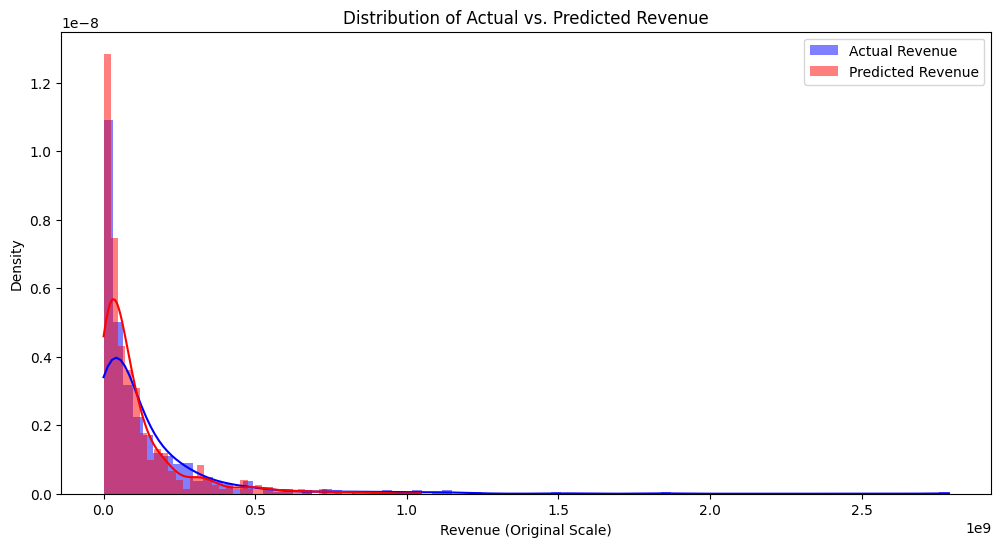

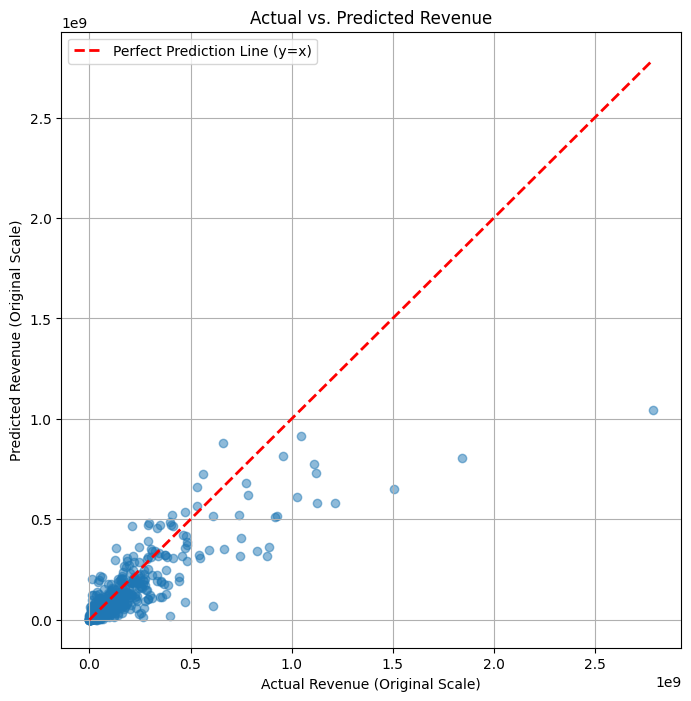

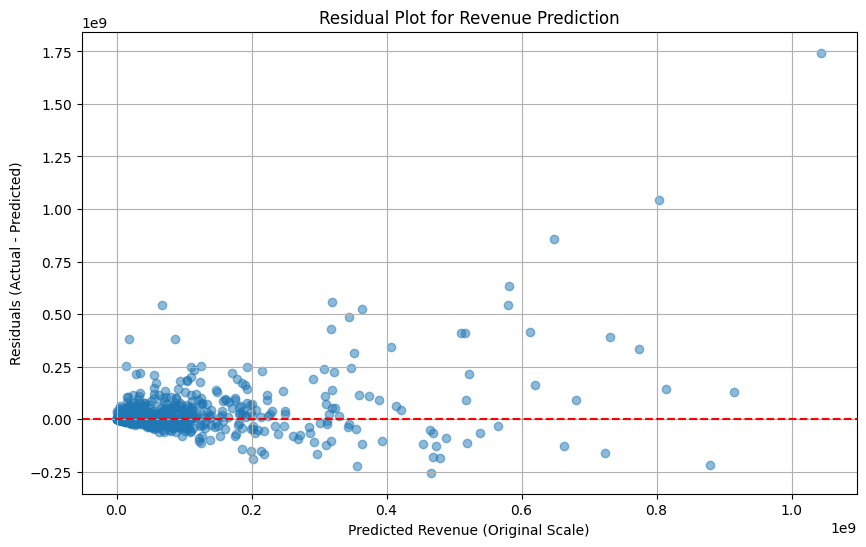

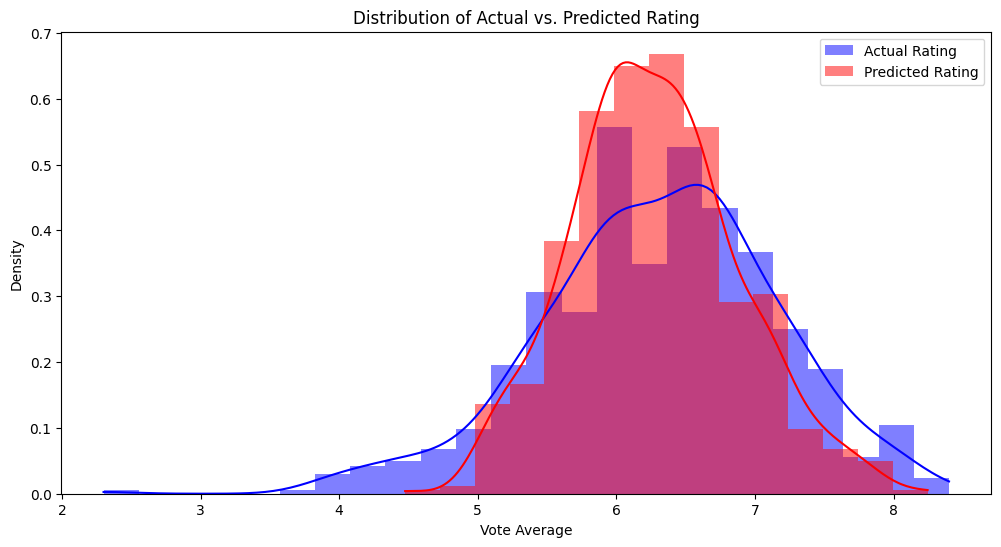

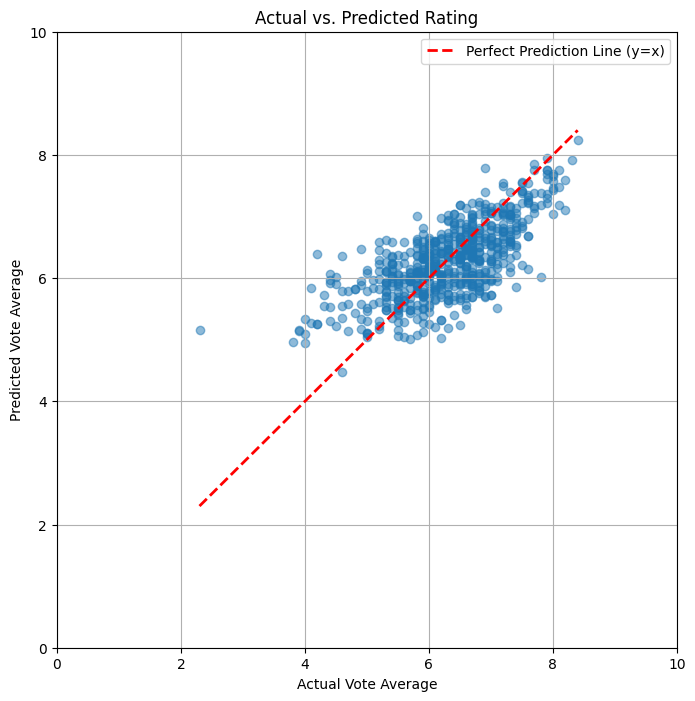

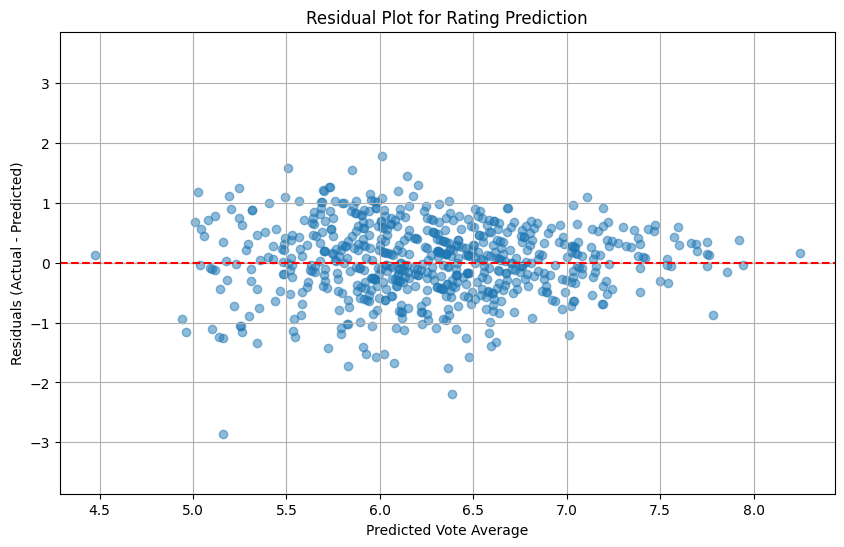


--- Feature Importances (Tabular, as before) ---

Feature Importances for Revenue Prediction (Sorted):
          Feature  Importance_for_Revenue
3      vote_count                0.510679
0      budget_log                0.230112
9    release_year                0.072895
1      popularity                0.038685
2         runtime                0.031957
7        num_crew                0.028934
6        num_cast                0.024864
10  release_month                0.023103
5    num_keywords                0.023065
4      num_genres                0.012401
8    has_homepage                0.003304

Feature Importances for Rating Prediction (Sorted):
          Feature  Importance_for_Rating
3      vote_count               0.309372
2         runtime               0.189683
0      budget_log               0.168543
9    release_year               0.090294
1      popularity               0.066699
6        num_cast               0.042078
7        num_crew               0.039563
5    num_ke

<ipython-input-14-35dd140e998d>:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance_for_Revenue', y='Feature', data=sorted_revenue_importances, palette="viridis")


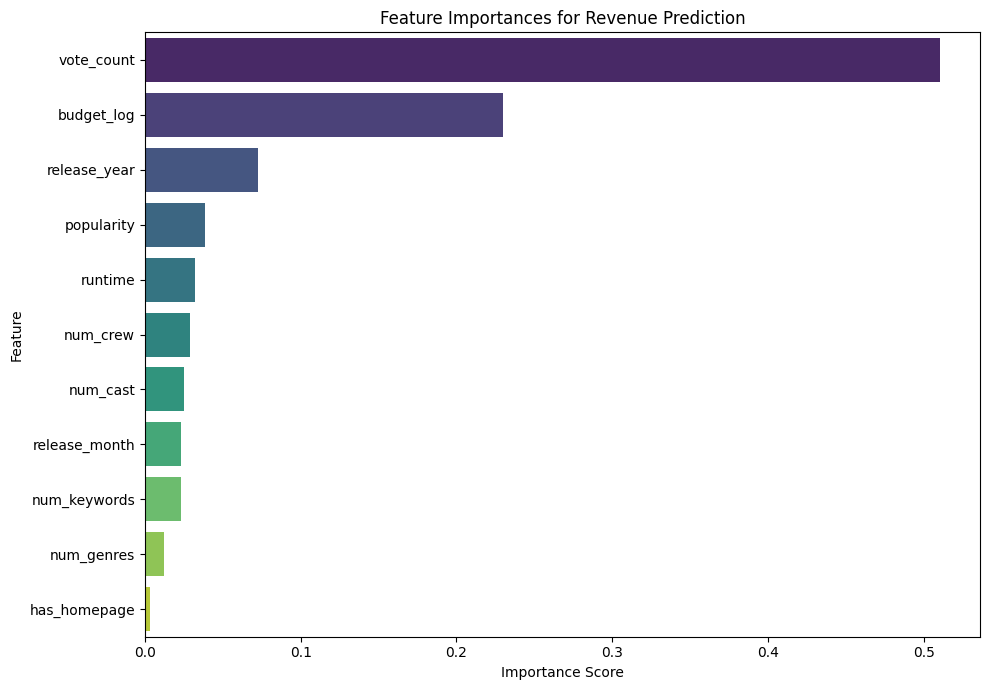

<ipython-input-14-35dd140e998d>:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance_for_Rating', y='Feature', data=sorted_rating_importances, palette="mako")


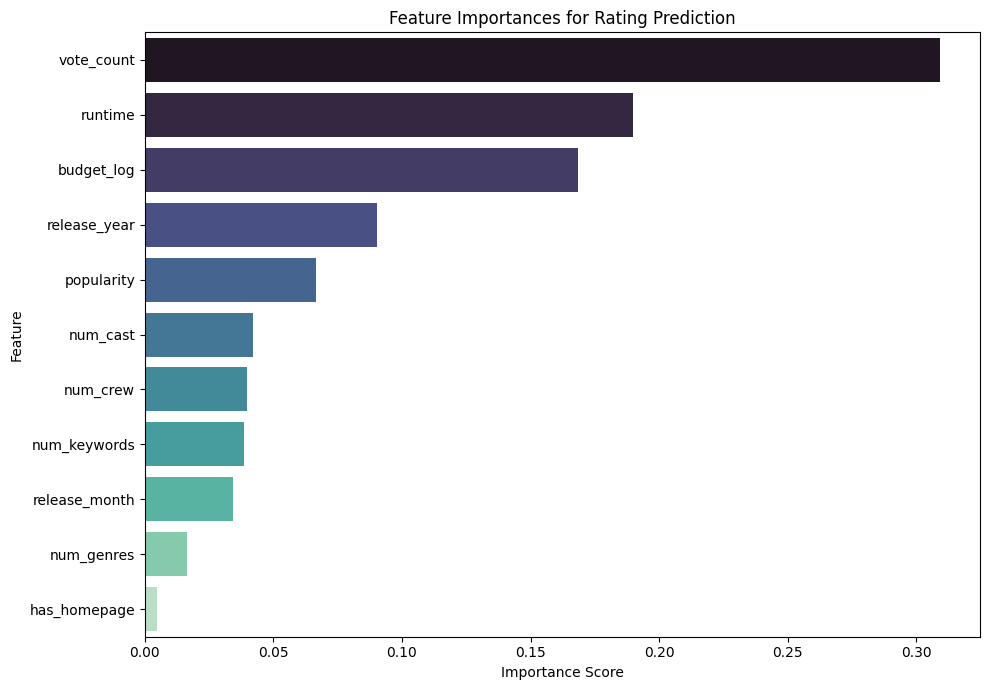


--- End of Project ---


In [ ]:
# (Previous code from Step 1 to Step 10 remains the same)

# Step 11: Evaluate the Model and Visualize Results

print("\n--- Step 11: Evaluate the Model and Visualize Results ---")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Ensure plotting libraries are imported if not done at the top
import matplotlib.pyplot as plt
import seaborn as sns

# --- Ensure seaborn style is set if not done globally ---
# sns.set_style("whitegrid") # You can set it here or globally

# Extract actual and predicted values for each target for clarity
# Revenue (original scale)
y_test_revenue_actual = y_test_actual_scale.iloc[:, 0].values # Actual revenue
y_pred_revenue_actual = y_pred_actual_scale[:, 0]            # Predicted revenue

# Vote Average (original scale)
y_test_rating_actual = y_test_actual_scale.iloc[:, 1].values # Actual rating
y_pred_rating_actual = y_pred_actual_scale[:, 1]            # Predicted rating

# --- Evaluation Metrics (as before) ---
print("\n--- Revenue Prediction Evaluation (Original Scale) ---")
rmse_revenue = np.sqrt(mean_squared_error(y_test_revenue_actual, y_pred_revenue_actual))
mae_revenue = mean_absolute_error(y_test_revenue_actual, y_pred_revenue_actual)
r2_revenue = r2_score(y_test_revenue_actual, y_pred_revenue_actual)
print(f"RMSE (Revenue): ${rmse_revenue:,.2f}")
print(f"MAE (Revenue): ${mae_revenue:,.2f}")
print(f"R2 Score (Revenue): {r2_revenue:.4f}")

print("\n--- Vote Average Prediction Evaluation ---")
rmse_rating = np.sqrt(mean_squared_error(y_test_rating_actual, y_pred_rating_actual))
mae_rating = mean_absolute_error(y_test_rating_actual, y_pred_rating_actual)
r2_rating = r2_score(y_test_rating_actual, y_pred_rating_actual)
print(f"RMSE (Rating): {rmse_rating:.4f}")
print(f"MAE (Rating): {mae_rating:.4f}")
print(f"R2 Score (Rating): {r2_rating:.4f}")


# --- VISUALIZATIONS ---

# 1. Distribution of Actual vs. Predicted Values (Revenue)
plt.figure(figsize=(12, 6))
sns.histplot(y_test_revenue_actual, color="blue", label="Actual Revenue", kde=True, stat="density", linewidth=0)
sns.histplot(y_pred_revenue_actual, color="red", label="Predicted Revenue", kde=True, stat="density", linewidth=0)
plt.title('Distribution of Actual vs. Predicted Revenue')
plt.xlabel('Revenue (Original Scale)')
plt.ylabel('Density')
plt.legend()
# Since revenue can have a very wide range and be skewed, a log scale on x-axis might be useful IF needed for visualization
# Be careful with log(0) or negative values if they exist before this point for y_pred_revenue_actual
# plt.xscale('log') # Uncomment if you want to try log scale for x-axis
plt.show()


# 2. Scatter Plot of Actual vs. Predicted Values (Revenue)
plt.figure(figsize=(8, 8))
plt.scatter(y_test_revenue_actual, y_pred_revenue_actual, alpha=0.5)
plt.plot([min(y_test_revenue_actual.min(), y_pred_revenue_actual.min()), max(y_test_revenue_actual.max(), y_pred_revenue_actual.max())],
         [min(y_test_revenue_actual.min(), y_pred_revenue_actual.min()), max(y_test_revenue_actual.max(), y_pred_revenue_actual.max())],
         color='red', linestyle='--', lw=2, label='Perfect Prediction Line (y=x)') # Line y=x
plt.title('Actual vs. Predicted Revenue')
plt.xlabel('Actual Revenue (Original Scale)')
plt.ylabel('Predicted Revenue (Original Scale)')
plt.legend()
plt.grid(True)
# plt.xscale('log') # Optional log scale
# plt.yscale('log') # Optional log scale
plt.show()


# 3. Residual Plot (Revenue)
residuals_revenue = y_test_revenue_actual - y_pred_revenue_actual
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_revenue_actual, residuals_revenue, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot for Revenue Prediction')
plt.xlabel('Predicted Revenue (Original Scale)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()


# 4. Distribution of Actual vs. Predicted Values (Rating)
plt.figure(figsize=(12, 6))
sns.histplot(y_test_rating_actual, color="blue", label="Actual Rating", kde=True, stat="density", linewidth=0, binwidth=0.25)
sns.histplot(y_pred_rating_actual, color="red", label="Predicted Rating", kde=True, stat="density", linewidth=0, binwidth=0.25)
plt.title('Distribution of Actual vs. Predicted Rating')
plt.xlabel('Vote Average')
plt.ylabel('Density')
plt.legend()
plt.show()


# 5. Scatter Plot of Actual vs. Predicted Values (Rating)
plt.figure(figsize=(8, 8))
plt.scatter(y_test_rating_actual, y_pred_rating_actual, alpha=0.5)
plt.plot([y_test_rating_actual.min(), y_test_rating_actual.max()],
         [y_test_rating_actual.min(), y_test_rating_actual.max()],
         color='red', linestyle='--', lw=2, label='Perfect Prediction Line (y=x)') # Line y=x
plt.title('Actual vs. Predicted Rating')
plt.xlabel('Actual Vote Average')
plt.ylabel('Predicted Vote Average')
plt.xlim(0, 10) # Ratings are typically 0-10
plt.ylim(0, 10)
plt.legend()
plt.grid(True)
plt.show()


# 6. Residual Plot (Rating)
residuals_rating = y_test_rating_actual - y_pred_rating_actual
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rating_actual, residuals_rating, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot for Rating Prediction')
plt.xlabel('Predicted Vote Average')
plt.ylabel('Residuals (Actual - Predicted)')
plt.ylim(-max(abs(residuals_rating.min()), abs(residuals_rating.max())) -1, max(abs(residuals_rating.min()), abs(residuals_rating.max())) +1 ) # Symmetrical y-axis
plt.grid(True)
plt.show()


# --- Feature Importances Plot (as before, but now with plotting) ---
if hasattr(model, 'estimators_') and len(model.estimators_) == 2:
    if isinstance(model.estimators_[0], RandomForestRegressor) and \
       isinstance(model.estimators_[1], RandomForestRegressor):

        print("\n--- Feature Importances (Tabular, as before) ---")
        importances_revenue_vals = model.estimators_[0].feature_importances_
        importances_rating_vals = model.estimators_[1].feature_importances_

        feature_importance_df = pd.DataFrame({
            'Feature': feature_cols, # Defined in Step 5
            'Importance_for_Revenue': importances_revenue_vals,
            'Importance_for_Rating': importances_rating_vals
        })

        print("\nFeature Importances for Revenue Prediction (Sorted):")
        sorted_revenue_importances = feature_importance_df[['Feature', 'Importance_for_Revenue']].sort_values(by='Importance_for_Revenue', ascending=False)
        print(sorted_revenue_importances)

        print("\nFeature Importances for Rating Prediction (Sorted):")
        sorted_rating_importances = feature_importance_df[['Feature', 'Importance_for_Rating']].sort_values(by='Importance_for_Rating', ascending=False)
        print(sorted_rating_importances)

        # 7. Plotting Feature Importances for Revenue
        plt.figure(figsize=(10, 7))
        sns.barplot(x='Importance_for_Revenue', y='Feature', data=sorted_revenue_importances, palette="viridis")
        plt.title('Feature Importances for Revenue Prediction')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

        # 8. Plotting Feature Importances for Rating
        plt.figure(figsize=(10, 7))
        sns.barplot(x='Importance_for_Rating', y='Feature', data=sorted_rating_importances, palette="mako")
        plt.title('Feature Importances for Rating Prediction')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
else:
    print("\nFeature importances cannot be displayed/plotted for the current model configuration.")

print("\n--- End of Project ---")